In [1]:
# ✅ 1. Install required libraries (run only once per environment)
# Use python -m pip to avoid "Access is denied" errors
!python -m pip install --user pandas numpy scikit-learn imbalanced-learn joblib

In [10]:
# ✅ 2. Import libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [19]:
# change to your CSV file path
filename = "datatransactions_3000.csv"
target = "isFraud"

df = pd.read_csv(filename)

# drop ID-like columns that add noise
for col in ["nameOrig", "nameDest", "transaction_id", "id"]:
    if col in df.columns:
        df = df.drop(columns=[col])

y = df[target].astype(int)
X = df.drop(columns=[target])

X.shape, y.value_counts()


((3000, 8),
 isFraud
 0    2993
 1       7
 Name: count, dtype: int64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [21]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])


In [22]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", clf)
])


In [23]:
param_distributions = {
    "smote__k_neighbors": [3, 5, 7],
    "clf__n_estimators": [200, 400, 600, 800],
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__bootstrap": [True, False],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,               # increase for better search
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)

search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['step',
                                                                                'amount',
                                                                                'oldbalanceOrg',
                                                                                'newbalanceOrig',
                                                                                'oldbalanceDest',
                                                                                'newbalanceDest',
                                                                                'isFlaggedFraud']...
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [None, 10, 20, 40],
                                        'clf__max_features': ['sqrt', 'log2',
                                                              None],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [200, 400, 600,
                                                              800],
                                        'smote__k_neighbors': [3, 5, 7]},
                   random_state=42, scoring='average_precision', verbose=2)

In [24]:
print("Best Params:", search.best_params_)
print("Best CV PR-AUC:", search.best_score_)


Best Params: {'smote__k_neighbors': 3, 'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': None, 'clf__bootstrap': False}
Best CV PR-AUC: 0.23582417582417584


In [25]:
best_model = search.best_estimator_

test_proba = best_model.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, test_proba)

prec, rec, thr = precision_recall_curve(y_test, test_proba)
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx-1] if best_idx > 0 else 0.5

y_pred = (test_proba >= best_thr).astype(int)

print("Hold-out PR-AUC:", ap)
print("Chosen threshold:", best_thr)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Hold-out PR-AUC: 1.0
Chosen threshold: 0.6171410282823238

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9983    0.9992       599
           1     0.5000    1.0000    0.6667         1

    accuracy                         0.9983       600
   macro avg     0.7500    0.9992    0.8329       600
weighted avg     0.9992    0.9983    0.9986       600



In [26]:
joblib.dump({
    "model": best_model,
    "threshold": best_thr,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
}, "fraud_model.pkl")

print("✅ Model saved to fraud_model.pkl")


✅ Model saved to fraud_model.pkl


In [28]:
bundle = joblib.load("fraud_model.pkl")
model = bundle["model"]
thr = bundle["threshold"]

# Example prediction on X_test
proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= thr).astype(int)
print(pred[:10])


[0 0 0 0 0 0 0 0 0 0]


In [29]:
# ✅ Evaluate the tuned model on test data

from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

# 1. Classification report
print("📊 Classification Report:")
print(classification_report(y_test, pred))

# 2. Confusion matrix
print("📌 Confusion Matrix:")
print(confusion_matrix(y_test, pred))

# 3. Average Precision (PR-AUC)
ap_score = average_precision_score(y_test, proba)
print("🔎 Average Precision (PR-AUC):", ap_score)

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       0.50      1.00      0.67         1

    accuracy                           1.00       600
   macro avg       0.75      1.00      0.83       600
weighted avg       1.00      1.00      1.00       600

📌 Confusion Matrix:
[[598   1]
 [  0   1]]
🔎 Average Precision (PR-AUC): 1.0


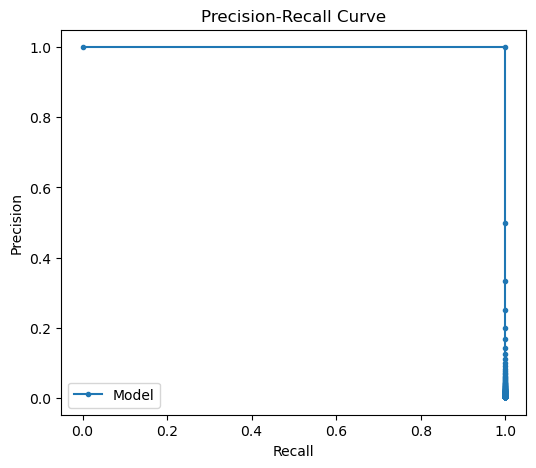

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label='Model')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()